<a href="https://colab.research.google.com/github/yuu067/MIA-IABD-2425/blob/main/UD04/notebooks/EX1.-Exercicis_OpenCV_ES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ejercicios de OpenCV

Hemos visto cómo ver funciones básicas de OpenCV. Ahora lo pondremos en práctica.

Tu tarea es poner en práctica lo que has aprendido en términos de procesamiento de imágenes con un ejemplo similar a lo que hemos visto en clase.

## Ejercicio 1

Usando OpenCV, cargando la imagen `camp.png`, encuentra los bordes y enmarcarlas en verde. Muestra el resultado.

## Ejercicio 2

Hemos visto cómo detectar el movimiento utilizando las diferencias entre dos _frames_ consecutivos. Ahora, carga `EX1.-vtest.mp4` y utiliza este método para detectar el movimiento en un video y usar la técnica vista en el ejemplo de la línea que rastrea el objeto que se está moviendo.

## Ejercicio 3

Calcular el flujo óptico de `vtest.mp4` y visualizalo.

In [82]:
# Instalamos las librerías necesarias

%pip install matplotlib opencv-python-headless

In [83]:
# Cargamos las librerías necesarias para la práctica

import numpy as np
import cv2
import matplotlib.pyplot as plt

(640, 960, 3)


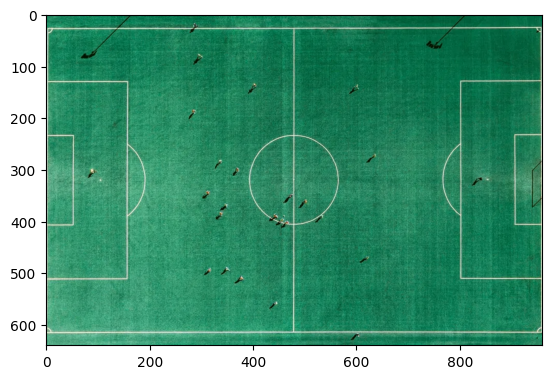

In [84]:
# Cargamos la imagen inicial:

im = cv2.imread("EX1.-camp.png")
print(im.shape)
plt.imshow(im)

In [85]:
im_bn = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
print(im_bn.shape)

(640, 960)


In [86]:
im_blurred = cv2.GaussianBlur(im_bn, (5, 5), 0)

In [87]:
ret, im_th = cv2.threshold(im_blurred,155,255,cv2.THRESH_BINARY_INV)

In [88]:
im_th_copy = im_th.copy()
contours, _ = cv2.findContours(im_th_copy, 1, cv2.CHAIN_APPROX_NONE)

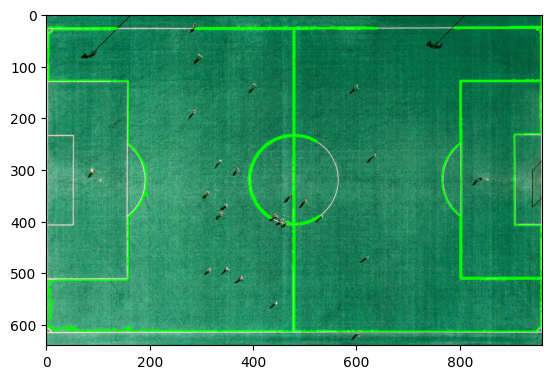

In [89]:
if len(contours) != 0:
    max_contour = max(contours, key = cv2.contourArea)
    cv2.drawContours(im, [max_contour], 0, (0, 255, 0), 2)
    plt.imshow(im)

Loaded 795 frames


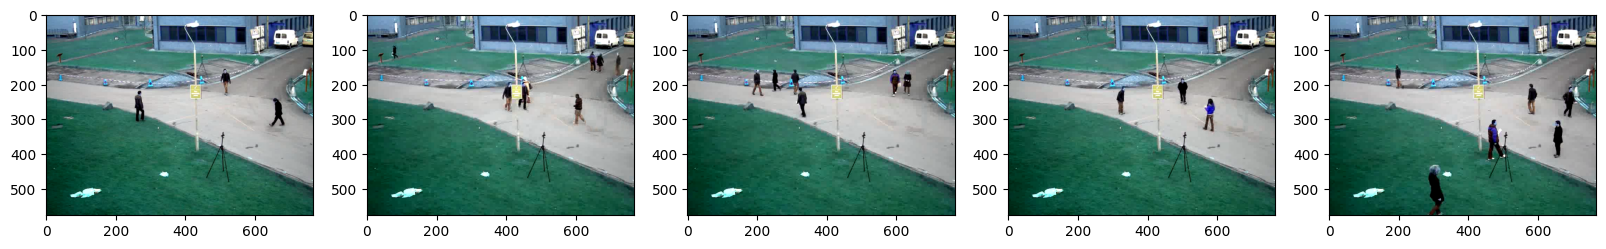

In [90]:
vid = cv2.VideoCapture("EX1.-vtest.mp4")

frames = []
while True:
    ret, frame = vid.read()
    if not ret:
        break
    frames.append(frame)

vid.release()
print(f"Loaded {len(frames)} frames")

# Mostrem els frames de 150 en 150 en una mateixa fila

fig, axs = plt.subplots(1, 5, figsize=(20, 20))
for i in range(5):
    axs[i].imshow(frames[i*150])


In [91]:
frames_bn = [cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) for frame in frames]

In [92]:
diffs = [(p2 - p1) for p1, p2 in zip(frames_bn[:-1], frames_bn[1:])]

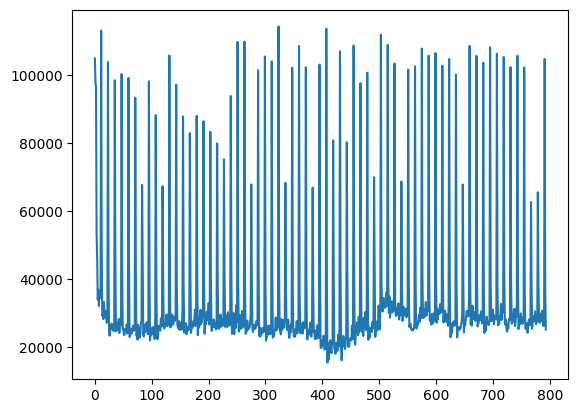

In [93]:
diffs_norms = np.array([np.linalg.norm(x) for x in diffs])

plt.plot(diffs_norms)

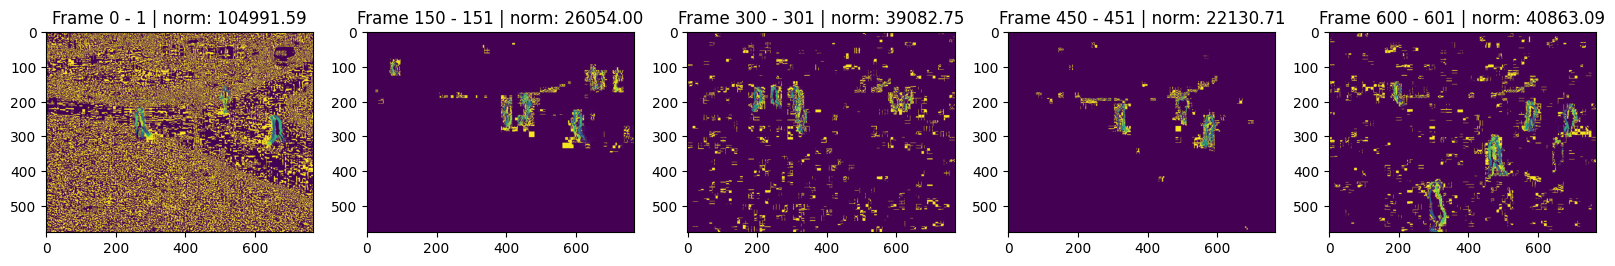

In [94]:
# Mostrem diffs de 150 en 150

fig, axs = plt.subplots(1, 5, figsize=(20, 20))
for i in range(5):
    axs[i].imshow(diffs[i*150])
    axs[i].set_title(f"Frame {i*150} - {i*150+1} | norm: {diffs_norms[i*150]:.2f}")

In [132]:
thresold = 30000
frames_moviment = [i for i, frame in enumerate(frames) if diffs_norms[i-1] > thresold]

frames_minims_event = 4

# Haurem de buscar les subsequències de frames_moviment que tinguin com a mínim frames_minims_event frames y no siguen consecutius

def find_events(frames_moviment, frames_minims_event):
    events = []
    event = []
    for i, frame in enumerate(frames_moviment):
        if len(event) == 0:
            event.append(frame)
        else:
            if frame - event[-1] == 1:
                event.append(frame)
            else:
                if len(event) >= frames_minims_event:
                    events.append(event)
                event = []
    return events

events = find_events(frames_moviment, frames_minims_event)
print(events)

[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], [503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519], [522, 523, 524, 525, 526, 527, 528, 529], [586, 587, 588, 589], [609, 610, 611, 612, 613], [718, 719, 720, 721]]


Event from frame 1 to frame 13
Event from frame 503 to frame 519
Event from frame 522 to frame 529
Event from frame 586 to frame 589
Event from frame 609 to frame 613
Event from frame 718 to frame 721


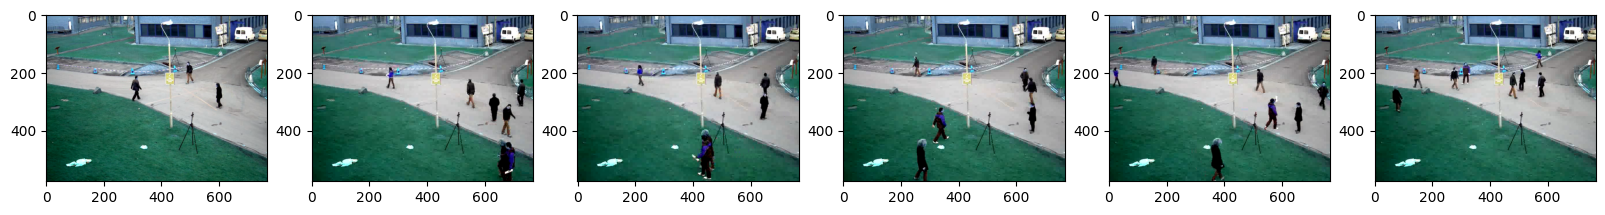

In [133]:
for event in events:
    print(f"Event from frame {event[0]} to frame {event[-1]}")

fig, axs = plt.subplots(1, len(events), figsize=(20, 20))
for i in range(len(events)):
    # Frame central de l'event
    frame = events[i][len(events[i])//2]
    axs[i].imshow(frames[frame])

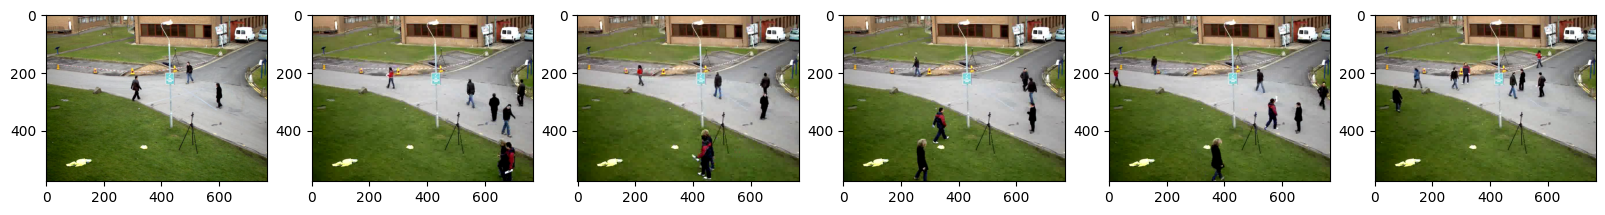

In [134]:
frames_rgb = [cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) for frame in frames]

fig, axs = plt.subplots(1, len(events), figsize=(20, 20))
for i in range(len(events)):
    # Frame central de l'event
    frame = events[i][len(events[i])//2]
    axs[i].imshow(frames_rgb[frame])

In [135]:
flows = [cv2.calcOpticalFlowFarneback(frames_bn[i], frames_bn[i+1], None, 0.5, 3, 15, 3, 5, 1.2, 0) for i in range(len(frames_bn)-1)]

flows[0].shape

(576, 768, 2)

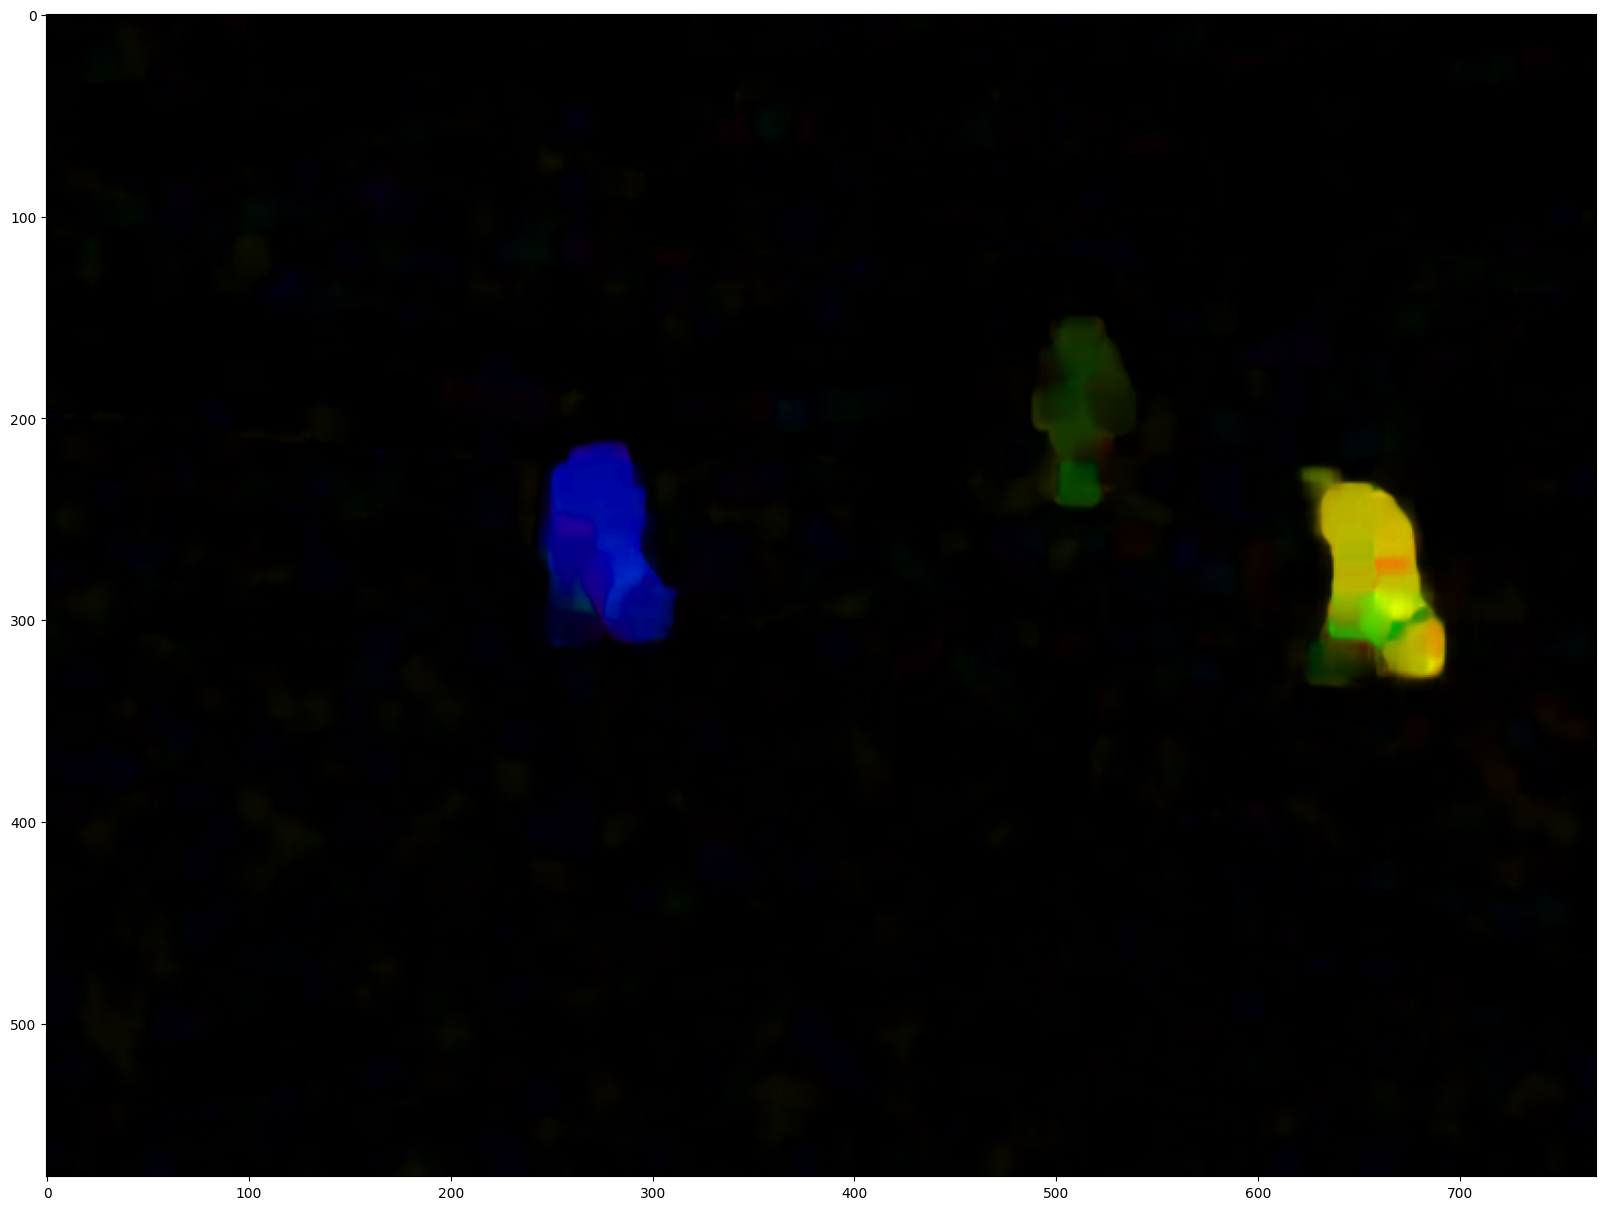

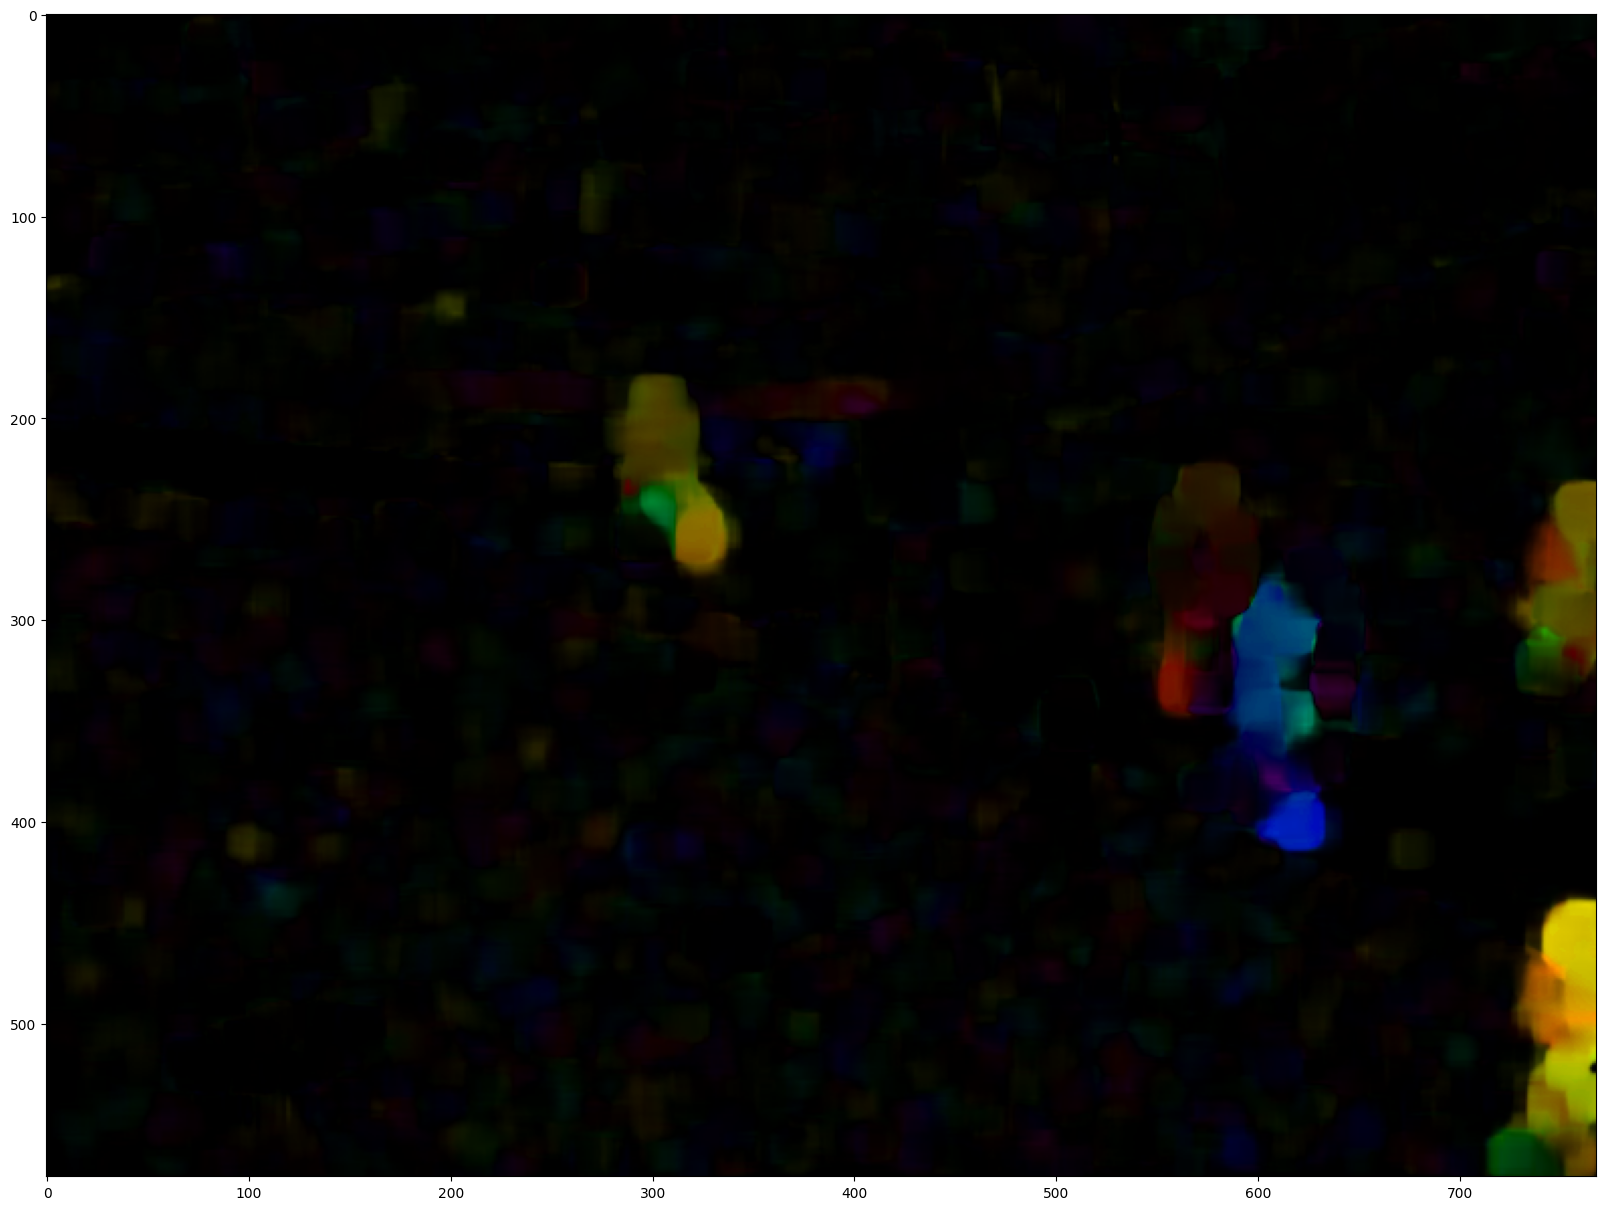

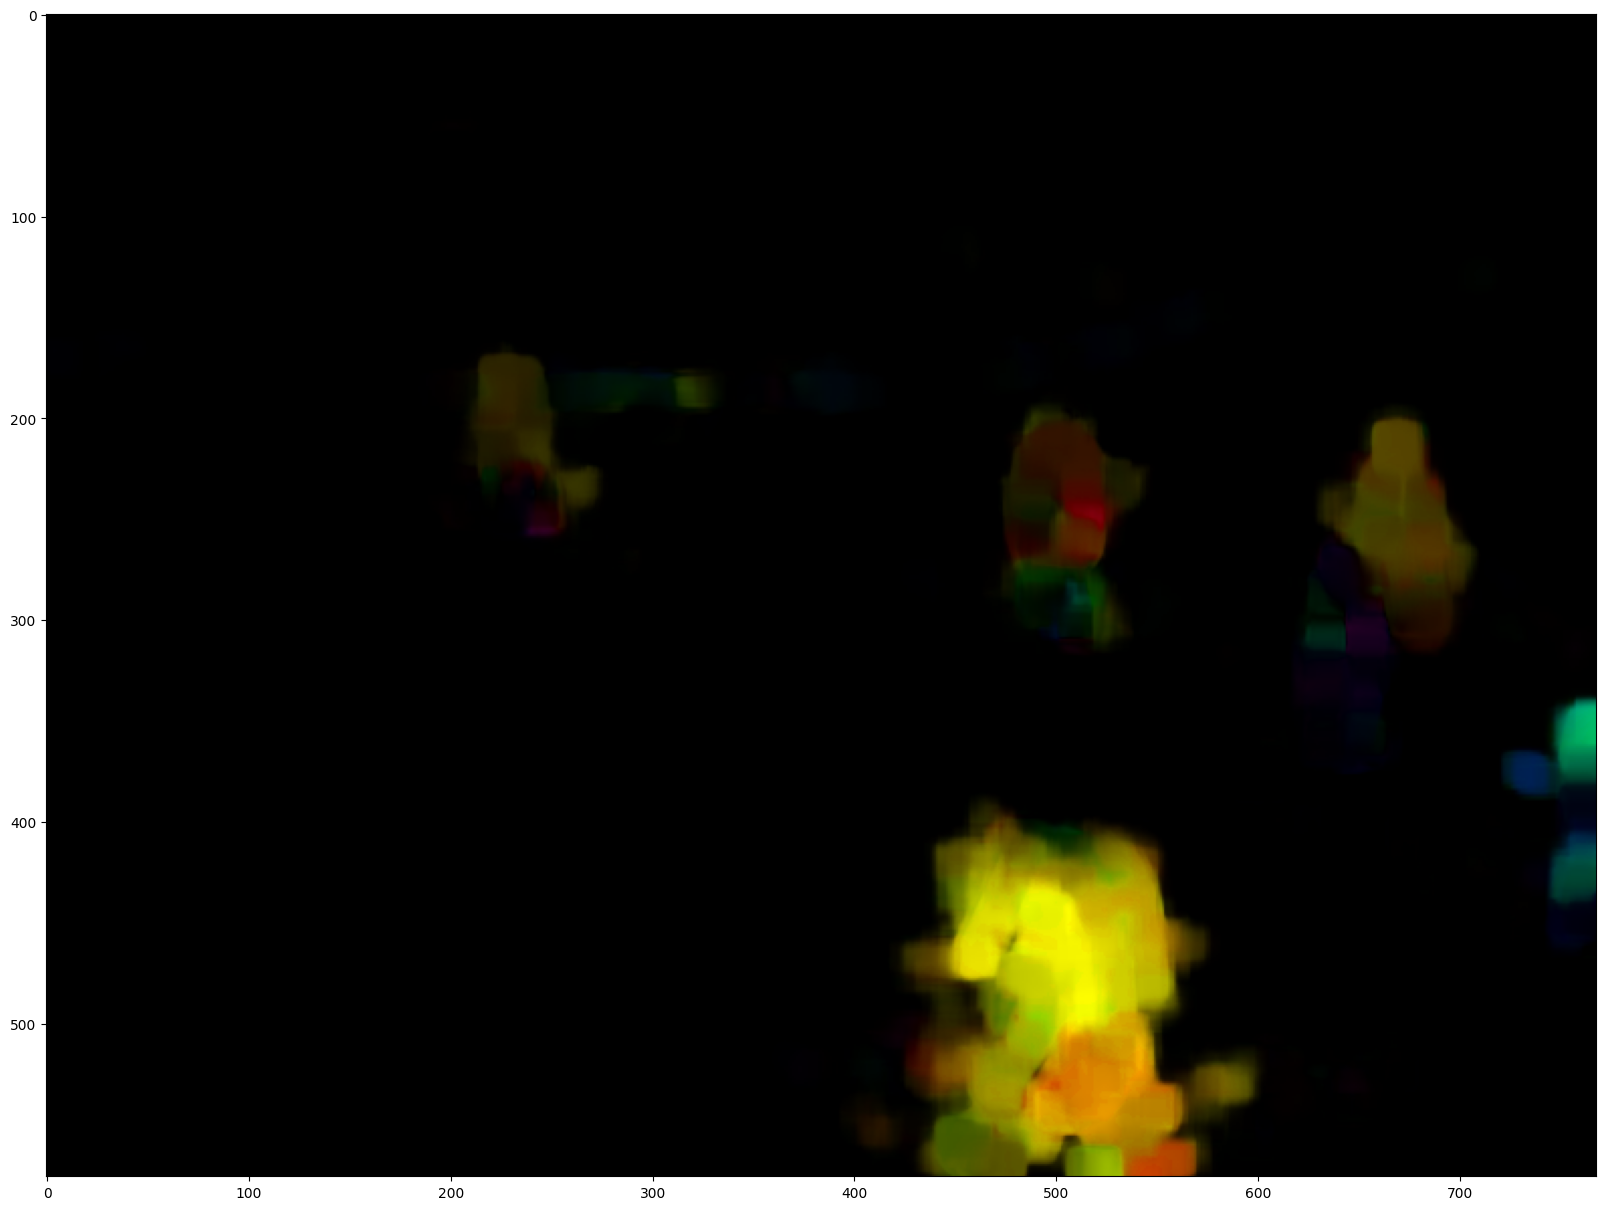

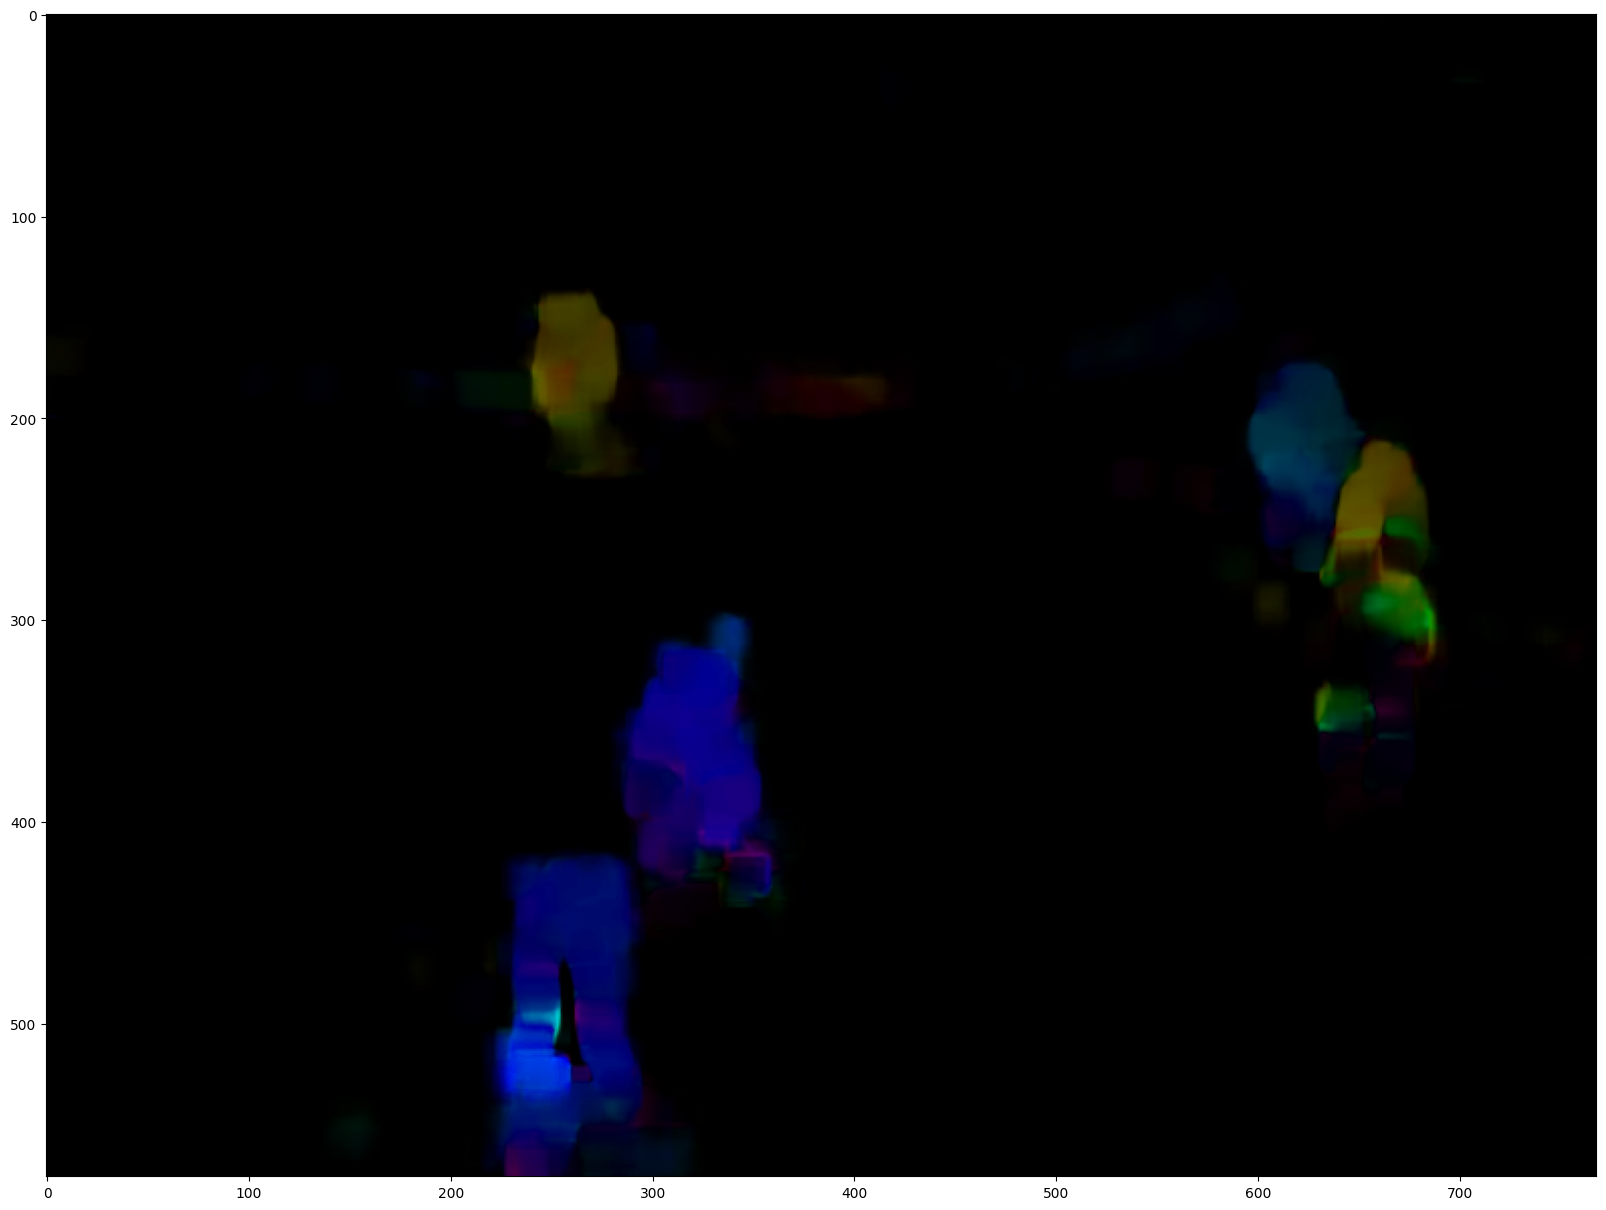

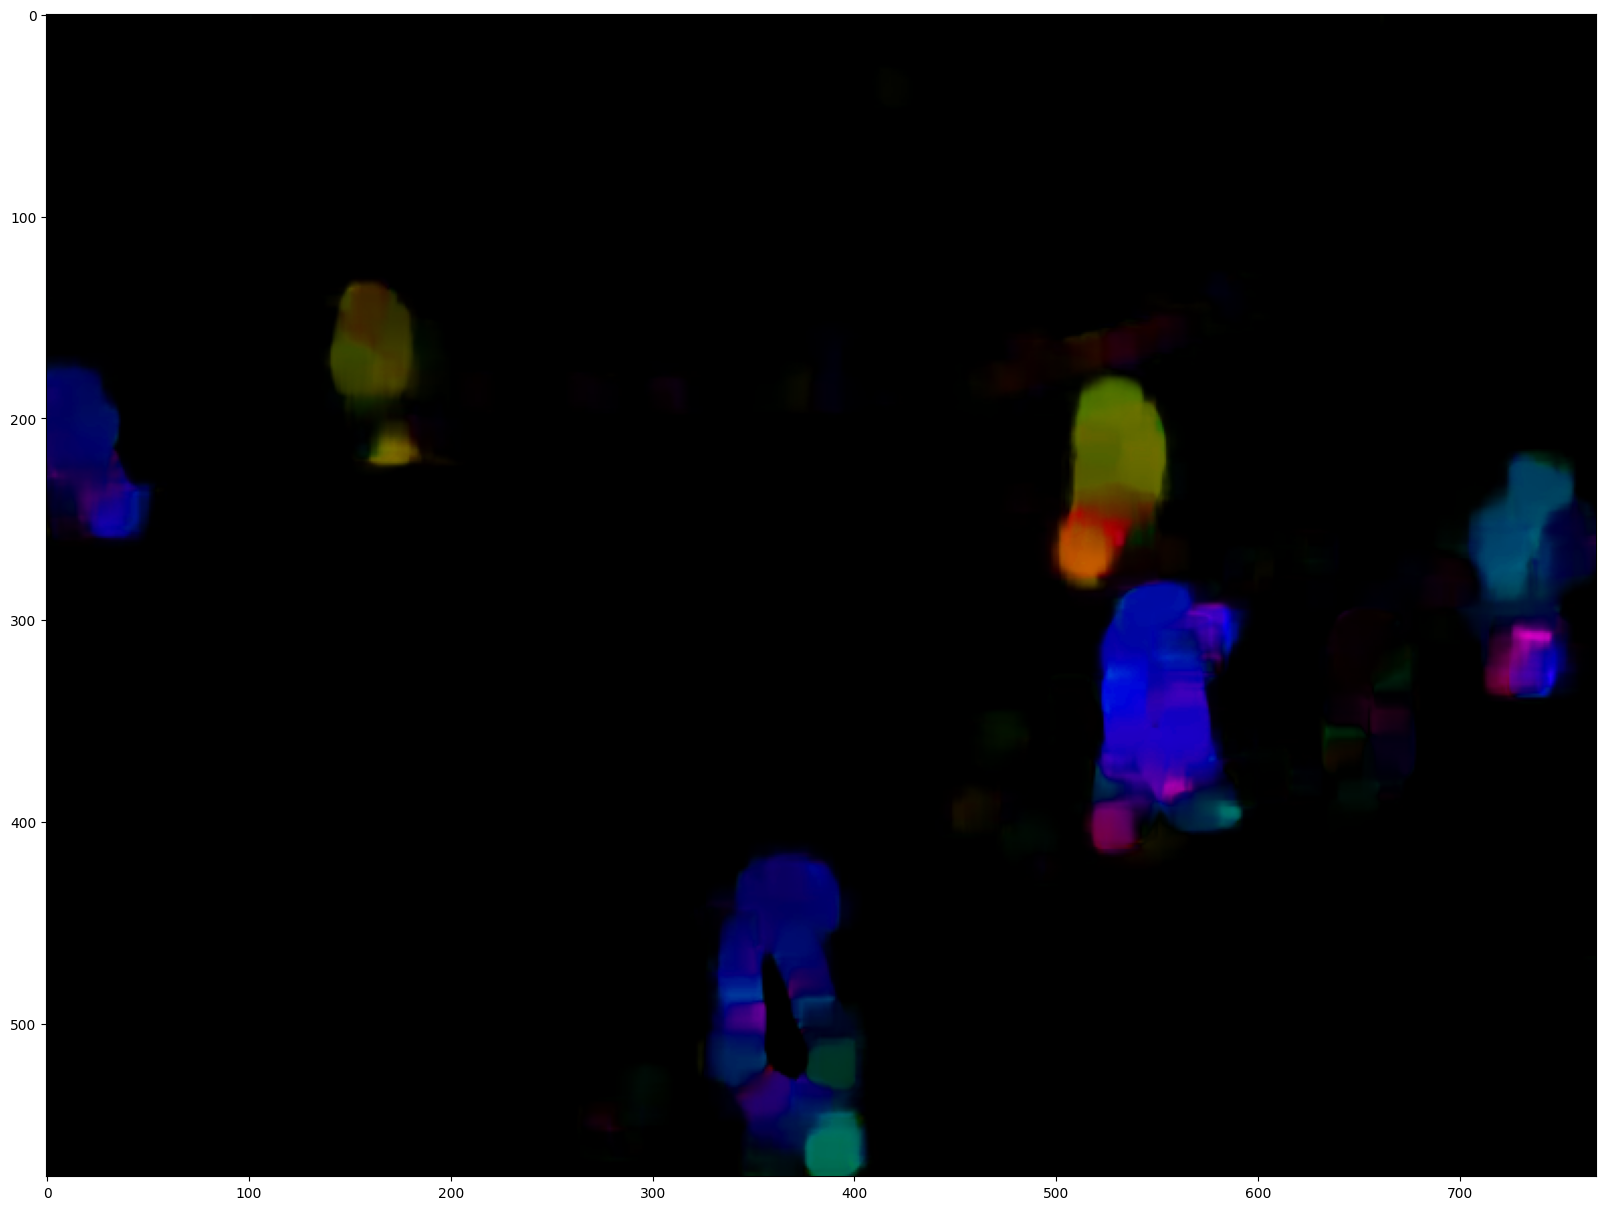

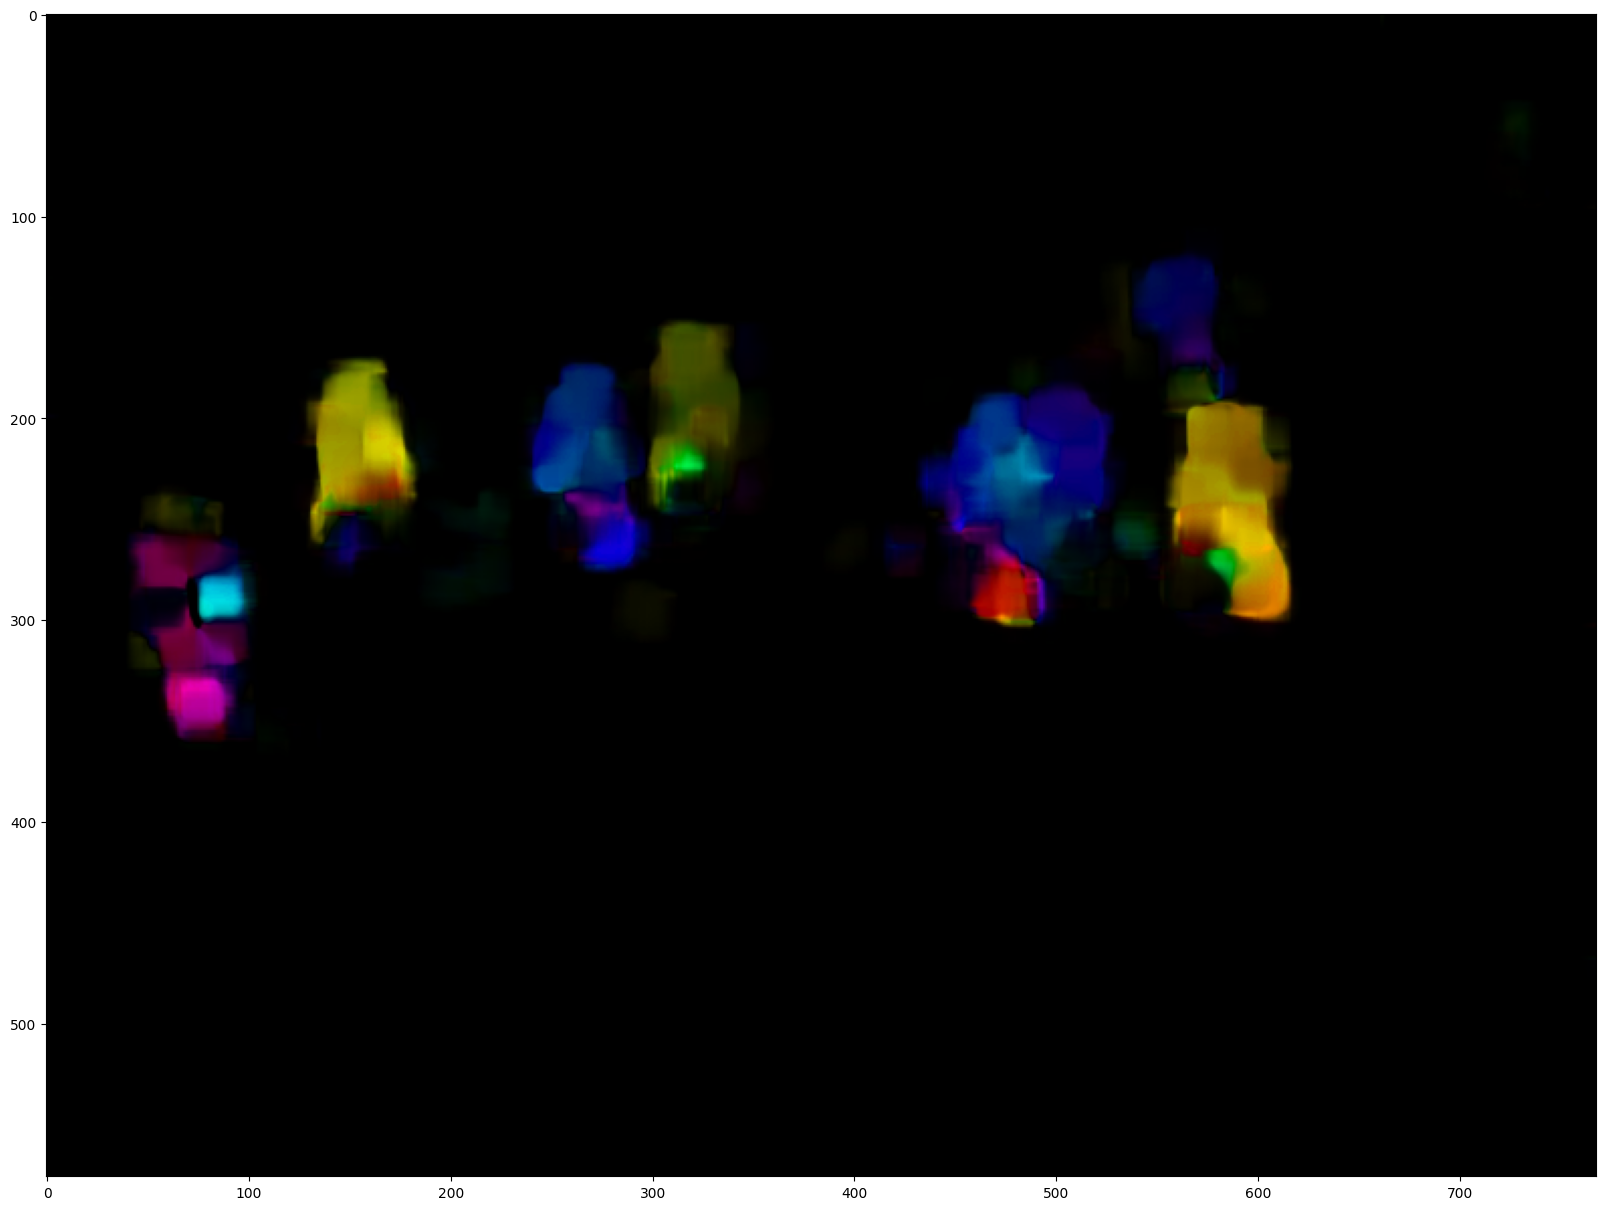

In [136]:
def flow_to_hsv(flow):
    hsvImg = np.zeros((flow.shape[0],flow.shape[1],3),dtype=np.uint8)
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsvImg[..., 0] = 0.5 * ang * 180 / np.pi
    hsvImg[..., 1] = 255
    hsvImg[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    return cv2.cvtColor(hsvImg, cv2.COLOR_HSV2BGR)


for event in events:
    start = event[0]
    stop = event[-1]
    frms = [flow_to_hsv(x) for x in flows[start:stop]]

    # Check if more than one subplot is requested
    num_subplots = len(frms) // 25 + 1
    if num_subplots > 1:
        fig, axs = plt.subplots(1, num_subplots, figsize=(20, 20))
        for i, flow in enumerate(frms[::25]):
            axs[i].imshow(flow)
    else:
        # If only one subplot is needed, use axs directly
        fig, axs = plt.subplots(figsize=(20, 20))
        axs.imshow(frms[0])